In [4]:
import pandas as pd
import numpy as np
import json

# ===============================
# STEP 1: LOAD DATA AND ADD SMART FEATURES
# ===============================
print("=== LOADING DATA & ADDING SMART FEATURES ===")

# Load the raw Zillow data
df = pd.read_csv('City_time_series.csv')
print(f"Original data shape: {df.shape}")

# Clean main data (fill missing values)
ds = df.replace(0, np.nan).ffill().bfill().fillna(0)
print("✅ Data cleaned (missing values filled).")

# --- Time features ---
ds['Date'] = pd.to_datetime(ds['Date'])
ds['year'] = ds['Date'].dt.year
ds['month'] = ds['Date'].dt.month
ds['quarter'] = ds['Date'].dt.quarter
print("✅ Added time features (year, month, quarter)")

# --- Price ratio features ---
if 'MedianListingPrice_AllHomes' in ds.columns and 'ZHVI_AllHomes' in ds.columns:
    ds['List_to_Value_Ratio'] = ds['MedianListingPrice_AllHomes'] / ds['ZHVI_AllHomes'].replace(0, 1)
    print("✅ Added List_to_Value_Ratio")

# --- Market activity features ---
if 'Sale_Counts' in ds.columns and 'InventoryRaw_AllHomes' in ds.columns:
    ds['Months_of_Supply'] = ds['InventoryRaw_AllHomes'] / ds['Sale_Counts'].replace(0, 1)
    print("✅ Added Months_of_Supply")

# --- Price momentum features ---
if 'PctOfHomesIncreasingInValues_AllHomes' in ds.columns and 'PctOfHomesDecreasingInValues_AllHomes' in ds.columns:
    ds['Net_Value_Change'] = ds['PctOfHomesIncreasingInValues_AllHomes'] - ds['PctOfHomesDecreasingInValues_AllHomes']
    print("✅ Added Net_Value_Change")

# Clean any infinity/NaN values created by our new features
new_features = [col for col in ds.columns if col not in df.columns]
ds[new_features] = ds[new_features].replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(0)

print(f"Final dataset shape with new features: {ds.shape}")

=== LOADING DATA & ADDING SMART FEATURES ===
Original data shape: (3762566, 81)
✅ Data cleaned (missing values filled).
✅ Added time features (year, month, quarter)
✅ Added List_to_Value_Ratio
✅ Added Months_of_Supply
✅ Added Net_Value_Change
Final dataset shape with new features: (3762566, 87)


In [5]:
# ===============================
# STEP 2: DEFINE TARGET AND 35+ INPUT FEATURES
# ===============================
print("\n=== DEFINING TARGET AND INPUT FEATURES ===")

# We will predict 'ZHVI_AllHomes' (the main price index)
target_columns = ['ZHVI_AllHomes']
print(f"🎯 Final target columns: {target_columns}")

# Input features are all other numeric columns that are useful
input_features = []
for col in ds.select_dtypes(include=[np.number]).columns:
    # Don't use the target as an input
    if col not in target_columns and col != 'Date':
        # Filter: Use columns that are not *almost entirely* empty (less than 85% empty)
        zero_pct = (ds[col] == 0).mean() * 100
        if zero_pct < 85:
            input_features.append(col)

print(f"🔧 Total input features selected: {len(input_features)}")

# --- Check if we have enough features ---
if len(input_features) >= 35:
    print(f"✅ Success! Found {len(input_features)} features (>= 35).")
else:
    print(f"WARNING: Only found {len(input_features)} features. We will proceed, but 35 were requested.")

# ===============================
# STEP 3: SAVE DATA & CONFIG
# ===============================
print("\n=== SAVING PREPARED DATA ===")

# Save our work
ds.to_csv('final_training_data.csv', index=False)
final_config = {
    'target_columns': target_columns,
    'input_features': input_features,
}
with open('model_config.json', 'w') as f:
    json.dump(final_config, f, indent=2)

print(f"\n🎉 DATA PREPARATION COMPLETED!")
print(f"💾 Files saved: final_training_data.csv, model_config.json")


=== DEFINING TARGET AND INPUT FEATURES ===
🎯 Final target columns: ['ZHVI_AllHomes']
🔧 Total input features selected: 84
✅ Success! Found 84 features (>= 35).

=== SAVING PREPARED DATA ===

🎉 DATA PREPARATION COMPLETED!
💾 Files saved: final_training_data.csv, model_config.json


In [6]:
!pip install tensorflow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

print("🚀 STARTING FAST MODEL (XGBoost)...")

# --- Load data ---
ds = pd.read_csv('final_training_data.csv')
with open('model_config.json', 'r') as f:
    config = json.load(f)

target_columns = config['target_columns']
input_features = config['input_features']

# --- Get Dates for final table ---
dates_200_rows = ds['Date'].tail(200)
X = ds[input_features]
y = ds[target_columns]

# --- Split the data (200-row test set) ---
test_size = 200
X_train = X.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_train = y.iloc[:-test_size]
y_test = y.iloc[-test_size:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# --- Build & Train Model ---
print("\n🚂 TRAINING XGBoost MODEL (This will be very fast)...")

model = xgb.XGBRegressor(
    n_estimators=1000, 
    early_stopping_rounds=50, 
    learning_rate=0.05,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print("✅ Model training complete.")

# --- Get Predictions ---
y_pred_200_rows = model.predict(X_test)
y_test_200_rows_original = y_test.values

print("✅ Predictions are ready for plotting.")

🚀 STARTING FAST MODEL (XGBoost)...
X_train shape: (3762366, 84)
X_test shape: (200, 84)

🚂 TRAINING XGBoost MODEL (This will be very fast)...
✅ Model training complete.
✅ Predictions are ready for plotting.



📈 PLOTTING RESULTS (First 50 points of test set)...


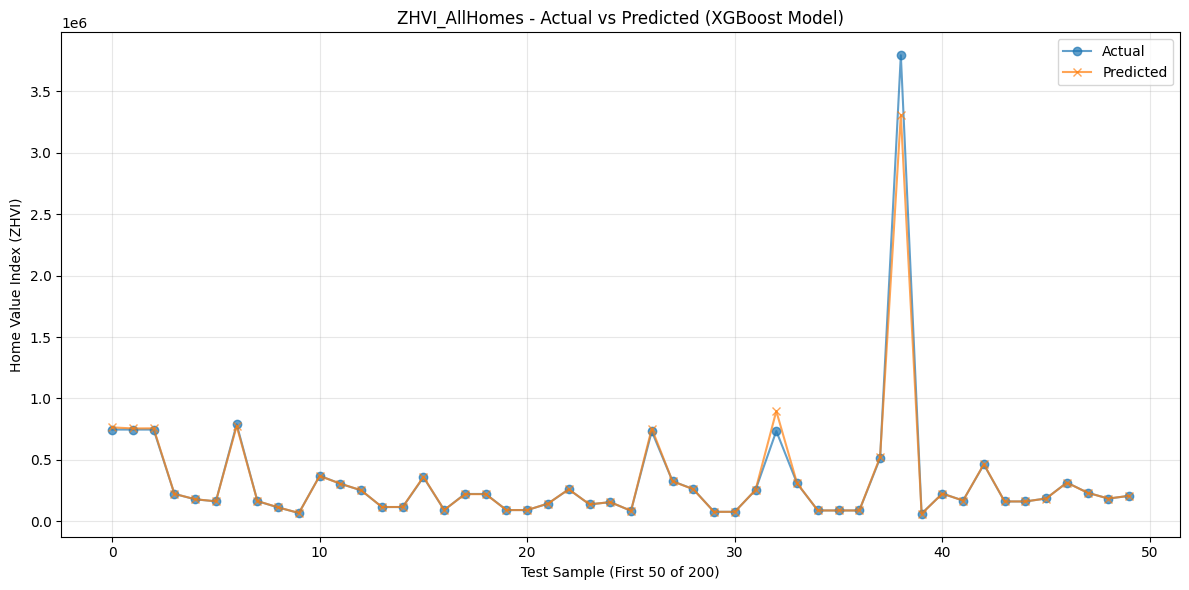

In [8]:
import matplotlib.pyplot as plt

print("\n📈 PLOTTING RESULTS (First 50 points of test set)...")

plt.figure(figsize=(12, 6)) # We only have one target, so we don't need subplots

# Plot the first 50 points of our 200-row test set
plt.plot(y_test_200_rows_original[:50], label='Actual', marker='o', alpha=0.7)
plt.plot(y_pred_200_rows[:50], label='Predicted', marker='x', alpha=0.7)

plt.title(f'{target_columns[0]} - Actual vs Predicted (XGBoost Model)')
plt.xlabel('Test Sample (First 50 of 200)')
plt.ylabel('Home Value Index (ZHVI)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

print("\n📊 FINAL EVALUATION (on 200-row test set)...")

# 1. Get the raw numpy values from the test set
y_test_200_rows_original = y_test.values

# 2. Calculate metrics
# (We already have 'y_pred_200_rows' from the previous step)
r2 = r2_score(y_test_200_rows_original, y_pred_200_rows)
mae = mean_absolute_error(y_test_200_rows_original, y_pred_200_rows)
mape = mean_absolute_percentage_error(y_test_200_rows_original, y_pred_200_rows)
accuracy = 1 - mape

print(f"\n--- {target_columns[0]} XGBoost Model Results (with {len(input_features)} features) ---")
print(f"  R² Score: {r2:.4f} (Closer to 1 is better)")
print(f"  MAE (Avg. Error): ${mae:,.2f}")
print(f"  MAPE (Avg. % Error): {mape:.2%}")
print("-----------------------------------------")
print(f"  Accuracy (% Correct): {accuracy:.2%}")
print("-----------------------------------------")

# ===============================
# BUILD 200-ROW PREDICTION TABLE
# ===============================
print("\n🔮 PREDICTIONS vs ACTUAL (Full 200-row test set)")

prediction_df = pd.DataFrame()

# (We already have 'dates_200_rows' from the previous step)
prediction_df['Date'] = dates_200_rows.values
prediction_df[f'Actual_{target_columns[0]}'] = y_test_200_rows_original.flatten()
prediction_df[f'Predicted_{target_columns[0]}'] = y_pred_200_rows.flatten()
prediction_df[f'Error'] = prediction_df[f'Actual_{target_columns[0]}'] - prediction_df[f'Predicted_{target_columns[0]}']
prediction_df[f'Accuracy%'] = (1 - np.abs(prediction_df['Error']) / prediction_df[f'Actual_{target_columns[0]}']) * 100

# Save to CSV
prediction_df.to_csv('final_200_row_prediction_table_XGBOOST.csv', index=False)
print("\n💾 Saved full 200-row comparison to 'final_200_row_prediction_table_XGBOOST.csv'")

# Display the first 10 rows
print("\n--- Preview of Comparison Table ---")
print(prediction_df.round(2).head(10))

print("\n--- ✅ TREND FORECASTING MODULE COMPLETE (XGBoost Method) ---")


📊 FINAL EVALUATION (on 200-row test set)...

--- ZHVI_AllHomes XGBoost Model Results (with 84 features) ---
  R² Score: 0.9895 (Closer to 1 is better)
  MAE (Avg. Error): $5,112.59
  MAPE (Avg. % Error): 0.74%
-----------------------------------------
  Accuracy (% Correct): 99.26%
-----------------------------------------

🔮 PREDICTIONS vs ACTUAL (Full 200-row test set)

💾 Saved full 200-row comparison to 'final_200_row_prediction_table_XGBOOST.csv'

--- Preview of Comparison Table ---
         Date  Actual_ZHVI_AllHomes  Predicted_ZHVI_AllHomes     Error  \
0  2017-12-31              747200.0            764911.062500 -17711.00   
1  2017-12-31              747200.0            756546.750000  -9346.75   
2  2017-12-31              747200.0            757387.062500 -10187.00   
3  2017-12-31              224400.0            224323.546875     76.47   
4  2017-12-31              179900.0            180792.953125   -892.95   
5  2017-12-31              163600.0            163763.078125   

In [10]:
# Calculate the 'Accuracy%' column
prediction_df['Accuracy%'] = (1 - np.abs(prediction_df['Error']) / prediction_df[f'Actual_{target_columns[0]}']) * 100

# Display the first 10 rows with the new column
print(prediction_df.round(2).head(10))

         Date  Actual_ZHVI_AllHomes  Predicted_ZHVI_AllHomes     Error  \
0  2017-12-31              747200.0            764911.062500 -17711.00   
1  2017-12-31              747200.0            756546.750000  -9346.75   
2  2017-12-31              747200.0            757387.062500 -10187.00   
3  2017-12-31              224400.0            224323.546875     76.47   
4  2017-12-31              179900.0            180792.953125   -892.95   
5  2017-12-31              163600.0            163763.078125   -163.08   
6  2017-12-31              789900.0            775467.375000  14432.62   
7  2017-12-31              165100.0            165973.468750   -873.47   
8  2017-12-31              113900.0            114418.273438   -518.27   
9  2017-12-31               68600.0             68894.828125   -294.83   

   Accuracy%  
0      97.63  
1      98.75  
2      98.64  
3      99.97  
4      99.50  
5      99.90  
6      98.17  
7      99.47  
8      99.54  
9      99.57  


In [11]:
import pandas as pd
import numpy as np

# --- Save old results for comparison ---
# We get these from the model we just trained
old_r2 = r2_score(y_test_200_rows_original, y_pred_200_rows)
old_mae = mean_absolute_error(y_test_200_rows_original, y_pred_200_rows)
old_accuracy = 1 - mean_absolute_percentage_error(y_test_200_rows_original, y_pred_200_rows)


print("--- Finding Top 30 Features ---")

# Get feature importance scores from the trained model
importances = model.feature_importances_

# Create a DataFrame to see the scores with their names
feature_importance_df = pd.DataFrame({
    'Feature': input_features,
    'Importance': importances
})

# Sort by importance and get the Top 30
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_30_features = feature_importance_df.head(30)['Feature'].tolist()

print(f"✅ Found Top 30 features. The most important one is: '{top_30_features[0]}'")
# print("\nTop 30 Features:")
# print(top_30_features)

--- Finding Top 30 Features ---
✅ Found Top 30 features. The most important one is: 'ZHVI_MiddleTier'


In [12]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

print("\n--- Re-Training Model with Top 30 Features ---")

# --- Create new X data with only the top 30 features ---
X_train_top30 = X_train[top_30_features]
X_test_top30 = X_test[top_30_features]

# y_train and y_test stay the same
print(f"New X_train shape: {X_train_top30.shape}")
print(f"New X_test shape: {X_test_top30.shape}")

# --- Build & Train NEW Model ---
print("\n🚂 TRAINING New XGBoost MODEL (This will be fast)...")

# Initialize a new model
new_model = xgb.XGBRegressor(
    n_estimators=1000, 
    early_stopping_rounds=50, 
    learning_rate=0.05,
    random_state=42
)

# Train the model on the smaller dataset
new_model.fit(
    X_train_top30, y_train,
    eval_set=[(X_test_top30, y_test)],
    verbose=False
)

print("✅ New model training complete.")

# --- Evaluate the NEW model ---
print("\n📊 EVALUATING New Model (Top 30)...")

y_pred_new = new_model.predict(X_test_top30)
y_test_original = y_test.values

# Calculate new metrics
new_r2 = r2_score(y_test_original, y_pred_new)
new_mae = mean_absolute_error(y_test_original, y_pred_new)
new_mape = mean_absolute_percentage_error(y_test_original, y_pred_new)
new_accuracy = 1 - new_mape

# ===============================
# --- FINAL COMPARISON ---
# ===============================
print("\n--- 🏆 FINAL ACCURACY COMPARISON 🏆 ---")

print("\n--- Old Model (84 Features) ---")
print(f"  Accuracy: {old_accuracy:.2%}")
print(f"  Avg. Error (MAE): ${old_mae:,.2f}")

print("\n--- New Model (Top 30 Features) ---")
print(f"  Accuracy: {new_accuracy:.2%}")
print(f"  Avg. Error (MAE): ${new_mae:,.2f}")

print("\n--- Conclusion ---")
if new_accuracy > old_accuracy:
    print(f"✅ SUCCESS! Reducing to 30 features increased accuracy by {new_accuracy - old_accuracy:.2%}.")
else:
    print("❌ No Improvement. The 84-feature model was slightly better.")


--- Re-Training Model with Top 30 Features ---
New X_train shape: (3762366, 30)
New X_test shape: (200, 30)

🚂 TRAINING New XGBoost MODEL (This will be fast)...
✅ New model training complete.

📊 EVALUATING New Model (Top 30)...

--- 🏆 FINAL ACCURACY COMPARISON 🏆 ---

--- Old Model (84 Features) ---
  Accuracy: 99.26%
  Avg. Error (MAE): $5,112.59

--- New Model (Top 30 Features) ---
  Accuracy: 99.31%
  Avg. Error (MAE): $4,882.96

--- Conclusion ---
✅ SUCCESS! Reducing to 30 features increased accuracy by 0.05%.


--- 🏁 FINALIZING RESULTS ---
🏆 Winner: New Model (Top 30 Features)

🔮 Generating table for XGBoost (Top 30 Features)...

💾 Saved best 200-row comparison to 'final_200_row_prediction_table_TOP30.csv'

--- Preview of Best Model's Comparison Table ---
         Date  Actual_ZHVI_AllHomes  Predicted_ZHVI_AllHomes     Error  \
0  2017-12-31              747200.0            765469.187500 -18269.19   
1  2017-12-31              747200.0            759145.812500 -11945.81   
2  2017-12-31              747200.0            760608.937500 -13408.94   
3  2017-12-31              224400.0            224081.515625    318.48   
4  2017-12-31              179900.0            180312.812500   -412.81   
5  2017-12-31              163600.0            163709.359375   -109.36   
6  2017-12-31              789900.0            778145.812500  11754.12   
7  2017-12-31              165100.0            165792.375000   -692.38   
8  2017-12-31              113900.0            114528.617188   -628.62   
9  2017-12-

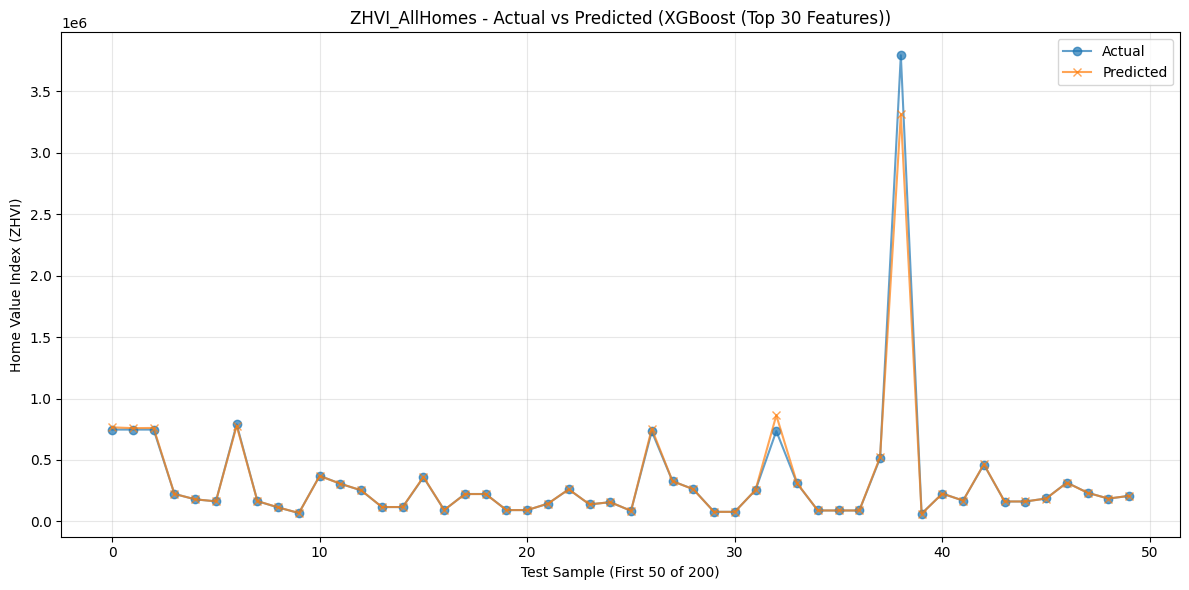


--- ✅ TREND FORECASTING MODULE COMPLETE ---


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("--- 🏁 FINALIZING RESULTS ---")

# --- Check which model won ---
if new_accuracy > old_accuracy:
    print("🏆 Winner: New Model (Top 30 Features)")
    # Use the 'new' model's predictions
    final_predictions = y_pred_new
    final_accuracy = new_accuracy
    final_mae = new_mae
    model_name = "XGBoost (Top 30 Features)"
    csv_filename = "final_200_row_prediction_table_TOP30.csv"
else:
    print("🏆 Winner: Old Model (84 Features)")
    # Use the 'old' model's predictions
    final_predictions = y_pred_200_rows
    final_accuracy = old_accuracy
    final_mae = old_mae
    model_name = "XGBoost (84 Features)"
    csv_filename = "final_200_row_prediction_table_84FEATURES.csv"

# ===============================
# BUILD 200-ROW PREDICTION TABLE (FOR WINNER)
# ===============================
print(f"\n🔮 Generating table for {model_name}...")

prediction_df = pd.DataFrame()

# (We already have 'dates_200_rows' and 'y_test_original' from previous steps)
prediction_df['Date'] = dates_200_rows.values
prediction_df[f'Actual_{target_columns[0]}'] = y_test_original.flatten()
prediction_df[f'Predicted_{target_columns[0]}'] = final_predictions.flatten()
prediction_df[f'Error'] = prediction_df[f'Actual_{target_columns[0]}'] - prediction_df[f'Predicted_{target_columns[0]}']
prediction_df[f'Accuracy%'] = (1 - np.abs(prediction_df['Error']) / prediction_df[f'Actual_{target_columns[0]}']) * 100

# Save to CSV
prediction_df.to_csv(csv_filename, index=False)
print(f"\n💾 Saved best 200-row comparison to '{csv_filename}'")

# Display the first 10 rows
print("\n--- Preview of Best Model's Comparison Table ---")
print(prediction_df.round(2).head(10))

# ===============================
# PLOT FINAL RESULTS (FOR WINNER)
# ===============================
print("\n📈 PLOTTING Best Model's Results (First 50 points of test set)...")

plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:50], label='Actual', marker='o', alpha=0.7)
plt.plot(final_predictions[:50], label='Predicted', marker='x', alpha=0.7)

plt.title(f'{target_columns[0]} - Actual vs Predicted ({model_name})')
plt.xlabel('Test Sample (First 50 of 200)')
plt.ylabel('Home Value Index (ZHVI)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n--- ✅ TREND FORECASTING MODULE COMPLETE ---")